In [14]:
import ogb
import torch
from torch_geometric.data import Data

In [2]:
from ogb.graphproppred import PygGraphPropPredDataset


In [3]:
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
print(dataset)

/Users/javiprietod/Documents/1º Master/Geometria/Sheaf-NN/.venv/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

PygGraphPropPredDataset(41127)


In [47]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader

# Download and process data at './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv')

split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx['train']], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset[split_idx['valid']], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx['test']], batch_size=32, shuffle=False)

/Users/javiprietod/Documents/1º Master/Geometria/Sheaf-NN/.venv/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

In [46]:
# print first batch
for batch in train_loader:
    print(batch)
    break

DataBatch(edge_index=[2, 1874], edge_attr=[1874, 3], x=[873, 9], y=[32, 1], num_nodes=873, batch=[873], ptr=[33])


In [68]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, in_ch=9, hid=64, num_classes=..., dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid)
        self.conv2 = GCNConv(hid, hid)
        self.lin   = torch.nn.Linear(hid, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        # Pooling por grafo -> [num_graphs, hid]
        x = global_mean_pool(x, batch)
        out = F.log_softmax(self.lin(x), dim=-1)    # para nll_loss
        return out


In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_classes=2).to(device)
data = next(iter(train_loader)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y.view(-1))
    loss.backward()
    optimizer.step()

In [105]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)                    # [num_graphs, num_classes]
        pred = out.argmax(dim=1)             # clase predicha
        correct += (pred == data.y.view(-1)).sum().item()
        total += data.y.size(0)

acc = correct / total
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.9684


In [106]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name='ogbg-molhiv')

# Collect predictions and true labels across the whole test set (not a single batch),
# and provide probability scores for the positive class to the evaluator.
y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
	for batch in test_loader:
		batch = batch.to(device)
		out = model(batch)                # log_softmax outputs
		prob_pos = out.exp()[:, 1]  
		y_true_list.append(batch.y.view(-1).cpu())
		y_pred_list.append(prob_pos.cpu())

y_true = torch.cat(y_true_list, dim=0).unsqueeze(1)  # shape [N,1]
y_pred = torch.cat(y_pred_list, dim=0).unsqueeze(1)  # shape [N,1]

input_dict = {'y_true': y_true, 'y_pred': y_pred}

# Guard against the case where all labels are the same (ROC-AUC undefined).
if y_true.sum() == 0 or y_true.sum() == y_true.numel():
	# Fallback: compute accuracy instead of ROC-AUC
	pred_labels = (y_pred >= 0.5).long()
	acc = (pred_labels.view(-1) == y_true.view(-1)).sum().item() / y_true.size(0)
	print("Warning: ROC-AUC cannot be computed because y_true contains only one class.")
	result_dict = {'accuracy': acc}
else:
	result_dict = evaluator.eval(input_dict)  # E.g., {'rocauc': 0.7321}

print(result_dict)

{'rocauc': 0.4361575155951254}


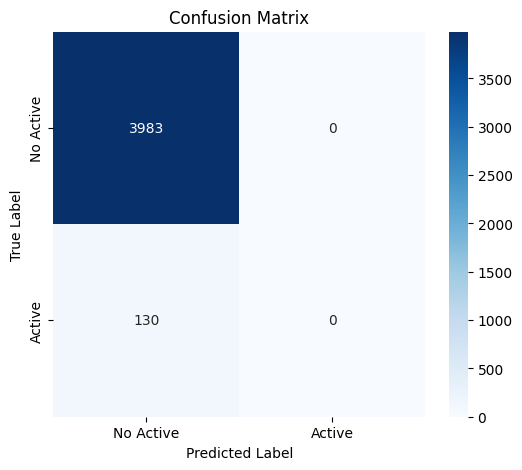

In [107]:
# classificatioin matriz
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = torch.cat(y_true_list, dim=0).numpy()
y_pred_labels = (torch.cat(y_pred_list, dim=0) >= 0.5).long().numpy()
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Active', 'Active'], yticklabels=['No Active', 'Active'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()